In [1]:
#import pyfair
from pyfair.model.model import FairModel
from pyfair.model.meta_model import FairMetaModel

import matplotlib
%matplotlib inline

import numpy as np
import pandas as pd

import pyfair

In [2]:
model1 = pyfair.FairModel(name="HA1", n_simulations=10_000)
model1.input_data('Loss Event Frequency', low=20, mode=100, high=900)
model1.input_data('Primary Loss', low=3_000_000, mode=3_500_000, high=5_000_000)
model1.input_multi_data('Secondary Loss', {
    'Secondary Loss Event Frequency': {
        'Reputational': {
            'low': .01,
            'mode': .80,
            'high': .99,
        }
    },
    'Secondary Loss Event Magnitude' : {
        'Reputational': {
            'low': 10_000,
            'mode': 20_000,
            'high': 100_000,
        }
    }
})

model1.calculate_all()

model2 = pyfair.FairModel(name="HA2", n_simulations=10_000)
model2.bulk_import_data({
    'Loss Event Frequency':    {'mean':.5, 'stdev':.1},
    'Loss Magnitude': {'low': 2_000_000_000, 'mode': 3_000_000_000, 'high': 5_000_000_000}
})
model2.calculate_all()

model3 = pyfair.FairModel(name="HA3", n_simulations=10_000)
model3.input_data('Loss Event Frequency', low=10, mode=15, high=16)
model3.input_data('Loss Magnitude', low=500_000_000, mode=500_900_000, high=600_000_000)
model3.calculate_all()



# Components

<section header and metadata>

<section overview>

* Summary General
    * Summary Table (mean, stdev, low, high, n)
    * hist
    * Exceedence curves
* Summary Comparison
    * Summary Table (mean, stdev, low, high, n)
    * Summary Table 2
    * Combined Hist
    * Exceedence curves
    
<section parameters>

* Model Detail
    * Parameter table with distributions
* Metamodel Detail
    * Risk table with stacked area
    
<section> and source code
* JSON

# Reports
* Compare
* Single
* Metamodel Drilldown

In [3]:
from pyfair.utility.factory import FairModelFactory

static = {
    "Loss Event Frequency": {
        "low": 20,
        "mode": 100,
        "high": 900
    },
}

variable = {
    'Model 1': {
        "Loss Magnitude": {
            "low": 3000000,
            "mode": 3500000,
            "high": 5000000
        }
    },
    'Model 2': {
        "Loss Magnitude": {
            "low": 300000,
            "mode": 350000,
            "high": 500000
        },
    }
}
    
factory = FairModelFactory(static)

factory.generate_from_partials(variable)

{'low': 20, 'mode': 100, 'high': 900}
{'low': 3000000, 'mode': 3500000, 'high': 5000000}
{'low': 20, 'mode': 100, 'high': 900}
{'low': 300000, 'mode': 350000, 'high': 500000}


(<Figure size 432x72 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2223b277c18>)

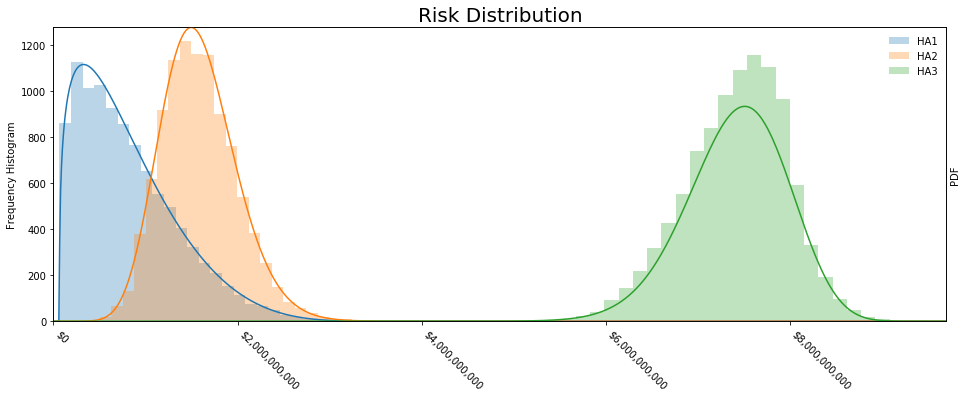

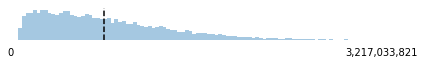

In [4]:
from pyfair.report.distribution import FairDistributionCurve

fdc = FairDistributionCurve([model1, model2, model3])
#fig, ax = fdc.generate_image()

fig, ax = fdc.generate_image()
fdc.generate_icon('HA1', 'Risk')

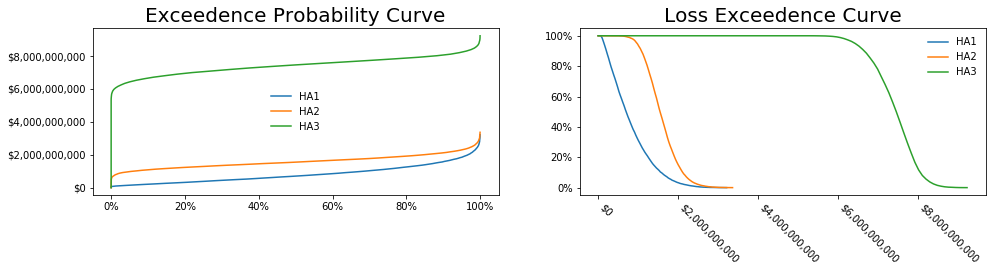

In [5]:
from pyfair.report.exceedence import FairExceedenceCurves

fpc = FairExceedenceCurves([model1, model2, model3])
fig1, ax1 = fpc.generate_image()

In [6]:
import numpy as np

In [51]:
import xlrd

import pandas as pd

from pyfair.model.meta_model import FairMetaModel
from pyfair.model.model import FairModel
from pyfair.report.simple_report import FairSimpleReport
from pyfair.utility.fair_exception import FairException


class FairSimpleParser(object):
    
    def __init__(self, workbook_path):
        self._path          = workbook_path
        self._names         = list()
        self._raw_data      = dict()
        self._n_simulations = None
        self._random_seed   = None
        self._output_path   = None
        self._data          = dict()
        self._models        = dict()
        self._metamodels    = dict()
        self._populate_object()
        self._split_frames()
        self._convert_to_models()
        self._create_metamodels()
    
    def to_html(self, path):
        metamodels = [item for item in self._metamodels.values() if item is not None]
        if metamodels:
            fsr = pyfair.FairSimpleReport(metamodels)
            fsr.to_html(path)
        else:
            raise FairException('Template is missing data.')
    
    def export_metamodels(self):
        return [item for item in self._metamodels.values()]
    
    def _create_metamodels(self):
        '''Create the metamodels'''
        for metamodel_name, model_list in self._models.items():
            if model_list:
                metamodel = FairMetaModel(
                    name=metamodel_name,
                    models=model_list
                )
                metamodel.calculate_all()
                self._metamodels[metamodel_name] = metamodel
            else:
                self._metamodels[metamodel_name] = None
    
    def _populate_object(self):
        '''Read sheet data into two huge frames'''
        # Read workbook
        wb = xlrd.open_workbook(self._path)
        # Create sheets via list comprehension
        self._names  = wb.sheet_names()
        # For tabs two and three
        for name in self._names[1:]:
            df = pd.read_excel(self._path, sheet_name=name)
            self._raw_data[name] = df
        # For tab 1
        df = pd.read_excel(self._path, sheet_name=self._names[0])
        # These should fail catastrophically if unpopulated.
        self._n_simulations = int(df.iloc[0, 1])
        self._random_seed = int(df.iloc[1, 1])
        self._output_path = df.iloc[2, 1]

    def _split_frames(self):
        '''For each of the main frames into components and store'''
        # For each big frame
        for designation, big_frame in self._raw_data.items():
            # Run the parse frame operation on the big frame
            rv = self._parse_raw_frame(big_frame)
            # Split rv into names, primary, and secondary
            model_name_series, primary_param_df, secondary_param_df = rv
            # Store as dict of dicts
            self._data[designation] = {
                'names'           : model_name_series,
                'primary_params'  : primary_param_df,
                'secondary_params': secondary_param_df,
            }
            
    def _convert_to_models(self):
        for designation, data in self._data.items():
            model_list = []
            for i in range(10):
                target         = self._data[designation]
                # ILOC because pandas is giving a weird error
                name           = target['names'].loc[i]
                raw_pri_params = target['primary_params'].loc[i]
                raw_sec_params = target['secondary_params'].loc[i]
                # Alias
                cdtpd = self._convert_df_to_param_dict
                # Run function
                ref_pri_params = cdtpd(raw_pri_params)
                ref_sec_params = cdtpd(raw_sec_params)
                ref_sec_params = {''.join('multi_', key): value for key, value in ref_sec_params.items()}
                # Create model
                if ref_pri_params:
                    model = FairModel(
                        name, 
                        n_simulations=self._n_simulations, 
                        random_seed=self._random_seed,
                    )
                    if ref_pri_params:
                        model.bulk_import_data(ref_pri_params)
                    if ref_sec_params:
                        model.input_multi_data('Secondary Loss Event Magnitude', ref_sec_params)
                    # Calculate
                    model.calculate_all()
                    model_list.append(model)
                else:
                    pass
            self._models[designation] = model_list
                
    def _parse_raw_frame(self, df):
        '''Take the raw data from the Excel sheet and generate 1 series and 2 frames'''
        # Groups of 12
        gb = df.groupby(df.index.values // 12)
        # Get names
        names = gb.apply(self._get_model_name)
        primary = gb.apply(self._get_model_primary_params)
        secondary = gb.apply(self._get_model_secondary_params)
        return (names, primary, secondary)

    def _get_model_name(self, df):
        '''Via gb.apply(): get model names'''
        name = df.iloc[0,1]
        return name

    def _get_model_primary_params(self, df):
        '''Via gb.apply(): drop last two rows from each entry, get columns low through constant'''
        main_df = df.iloc[:-2, 3:12]
        main_df = main_df.set_index('Target Name')
        return main_df

    def _get_model_secondary_params(self, df):
        '''Via gb.apply(): drop last rows from each entry, get columns Loss Name through SLEM'''
        # Chop down to 
        secondary_df = df.iloc[:-2, 13:16]
        secondary_df = secondary_df.set_index('Loss Name')
        return secondary_df

    def _convert_df_to_param_dict(self, df):
        ''' Convenience function to convert dataframe to dict.
        Converts: 
        
            pd.DataFrame({
                    'col_1': ['a'   , 'b', np.NaN],
                    'col_2': [np.NaN, 'c', np.NaN]
                },
                index=['row_1', 'row_2', 'row_3']
            )

        To:
        
            {
                'row_1': {'col_1': 'a'}, 
                'row_2': {'col_1': 'b', 'col_2': 'c'}
            }
        '''
        print(df)
        # Drop all rows without entries
        df = df.dropna(how='all', axis=0)
        # Make a dict from each row of params, dropping empty entries
        param_series = df.apply(lambda row: row.dropna().to_dict(), axis=1)
        # Make a dict from that series of dicts, giving us out multidimensional dict
        rv_dict = param_series.to_dict()
        return rv_dict   
        
        
fsp = FairSimpleParser('C:/Users/theon/development/data_entry.xlsx')
fsp.to_html('C:/Users/theon/Documents/output.html')


                          low mode high gamma mean stdev    p constant
  Target Name                                                         
0 Loss Event Frequency    100  110  150   NaN  NaN   NaN  NaN      NaN
  Threat Event Frequency  NaN  NaN  NaN   NaN  NaN   NaN  NaN      NaN
  Vulnerability           NaN  NaN  NaN   NaN  NaN   NaN  NaN      NaN
  Contact                 NaN  NaN  NaN   NaN  NaN   NaN  NaN      NaN
  Action                  NaN  NaN  NaN   NaN  NaN   NaN  NaN      NaN
  Threat Capability       NaN  NaN  NaN   NaN  NaN   NaN  NaN      NaN
  Control Strength        NaN  NaN  NaN   NaN  NaN   NaN  NaN      NaN
  Loss Magnitude          NaN  NaN  NaN   NaN  NaN   NaN  NaN     5000
  Primary Loss            NaN  NaN  NaN   NaN  NaN   NaN  NaN      NaN
  Secondary Loss          NaN  NaN  NaN   NaN  NaN   NaN  NaN      NaN
{(0, 'Loss Event Frequency'): {'low': 100, 'mode': 110, 'high': 150}, (0, 'Loss Magnitude'): {'constant': 5000}}
            Secondary Loss Event Fr

KeyError: (0, 'Loss Event Frequency')

In [10]:
fsp._raw_data['meta_model_1']

NameError: name 'fsp' is not defined

In [ ]:
tdf.iloc[0, 1] = .7
tdf.iloc[1, 1] = .7
tdf.iloc[1, 2] = .9
tdf.dropna(how='all', axis=0)
#tdf.apply(lambda row: row.dropna().to_dict(), axis=1).to_dict()

In [ ]:
tdf.dropna(how='all', axis=0)

In [24]:
df = pd.DataFrame({'a': [np.NaN, np.NaN], 'b': [np.NaN, np.NaN]})
df.loc[0]

a   NaN
b   NaN
Name: 0, dtype: float64